In [25]:
import sys

sys.path.append('./../../notebooks')
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from notebooks.core import model_utils

from transformers import AutoTokenizer, DataCollatorWithPadding
from datasets import Dataset

In [26]:
df = pd.read_json('../../data/translated/sarcasm/sarcasm_headlines_dataset_pl.json')
df = df.drop(columns=['headline', 'article_link'])
df.rename(columns={'is_sarcastic': 'label', 'headline_pl': 'text'}, inplace=True)
df

,label,text
0,1,Naukowcy z lat trzydziestych odkrywają zegar z...
1,0,"Reprezentantka rządu USA wyjaśnia, dlaczego Ko..."
2,0,Jedz warzywa: 9 pysznie różnych przepisów
3,1,Nieprzyjemna pogoda uniemożliwia kłamcy dotarc...
4,1,"matka jest bardzo blisko użycia słowa ""streami..."
...,...,...
28614,1,Żydzi świętują Rosh Hashasha czy coś
28615,1,Śledczy spraw wewnętrznych rozczarowany spiski...
28616,0,Najpiękniejsza przemowa akceptacyjna w tym tyg...
28617,1,Mars zniszczony przez pałac kosmiczny na orbic...


In [27]:
test_dataset = Dataset.from_pandas(df).remove_columns("__index_level_0__")
test_dataset

Dataset({
    features: ['label', 'text'],
    num_rows: 28619
})

In [28]:
# Load models
version = "1"
trained_bert = os.path.join("./../../trained_models/sarcasm_pl_bert_1", version)
trained_gpt = os.path.join("./../../trained_models/sarcasm_pl_gpt2_1", version)

bert = tf.keras.models.load_model(trained_bert)
gpt2 = tf.keras.models.load_model(trained_gpt)

In [29]:
bert.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (Custom>TFBertMainLayer multiple                  132121344 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 132,122,882
Trainable params: 132,122,882
Non-trainable params: 0
_________________________________________________________________


In [30]:
gpt2.summary()

Model: "tfgp_t2for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
score (Dense)                multiple                  1536      
_________________________________________________________________
transformer (Custom>TFGPT2Ma multiple                  124439808 
Total params: 124,441,344
Trainable params: 124,441,344
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Create BERT tokenizer and collator
bert_checkpoint = "dkleczek/bert-base-polish-uncased-v1"

bert_tokenizer = AutoTokenizer.from_pretrained(bert_checkpoint, model_max_length=512)


def tokenize_for_bert(example):
    return bert_tokenizer(example["text"], truncation=True)


bert_tokenized_test_dataset = test_dataset.map(tokenize_for_bert, batched=True)

bert_input_columns = ["attention_mask", "input_ids", "token_type_ids"]
bert_label_columns = ['label']
bert_batch_size = 16
bert_data_collator = DataCollatorWithPadding(tokenizer=bert_tokenizer, return_tensors="tf")
bert_tf_dataset = model_utils.convert_to_tf_dataset(bert_tokenized_test_dataset, bert_input_columns, bert_label_columns,
                                                    bert_data_collator, bert_batch_size)

Map:   0%|          | 0/28619 [00:00<?, ? examples/s]

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [32]:
# Create GPT2 tokenizer
gpt_checkpoint = MAX_TOKENS = 128
EOS_TOKEN = "<|endoftext|>"
checkpoint = "flax-community/papuGaPT2"

gpt2_tokenizer = AutoTokenizer.from_pretrained(
    checkpoint,
    eos_token=EOS_TOKEN,
    pad_token=EOS_TOKEN,
    max_length=MAX_TOKENS,
    is_split_into_words=True,
)

gpt2_tokenizer.padding_side = "left"


def tokenize_for_gpt2(examples):
    examples = [ex + EOS_TOKEN for ex in examples['text']]

    output = gpt2_tokenizer(
        examples,
        add_special_tokens=True,
        max_length=MAX_TOKENS,
        truncation=True,
        padding=True,
    )

    # truncate input ids and attention mask to account for label shift
    output["input_ids"] = [x[:-1] for x in output["input_ids"]]
    output["attention_mask"] = [x[:-1] for x in output["attention_mask"]]
    return output


gpt2_tokenized_test_dataset = test_dataset.map(tokenize_for_gpt2, batched=True)

gpt2_input_columns = ["input_ids", "attention_mask"]
gpt2_label_columns = ["label"]
gpt2_batch_size = 16
gpt2_data_collator = DataCollatorWithPadding(tokenizer=gpt2_tokenizer, return_tensors="tf")
gpt2_tf_dataset = model_utils.convert_to_tf_dataset(gpt2_tokenized_test_dataset, gpt2_input_columns, gpt2_label_columns,
                                                    gpt2_data_collator, gpt2_batch_size)

Map:   0%|          | 0/28619 [00:00<?, ? examples/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [160]:
def combine_probabilities(model1_probabilities, model2_probabilities, model1_weights, model2_weights):
    weighted_avg_probabilities = (model1_weights * model1_probabilities + model2_weights * model2_probabilities) / (model1_weights + model2_weights)
    normalized_probabilities = weighted_avg_probabilities / np.sum(weighted_avg_probabilities, axis=1, keepdims=True)

    return normalized_probabilities


def hybrid_predict(bert_input, gpt2_input, bert_model, gpt2_model, bert_weights, gpt2_weights):
    bert_probabilities = model_utils.get_class_preds(bert_model, bert_input, return_classes=False)
    gpt2_probabilities = model_utils.get_class_preds(gpt2_model, gpt2_input, return_classes=False)
    final_output = combine_probabilities(bert_probabilities, gpt2_probabilities, bert_weights, gpt2_weights)
    return final_output

In [161]:
bert_weights = np.array([88, 88, 88, 87, 94, 76])
gpt2_weights = np.array([91, 82, 87, 81, 92, 84])
word2vec_weights = np.array([52, 53, 54, 45, 43, 48])

hybrid_preds = hybrid_predict(
    bert_input=bert_tf_dataset, gpt2_input=gpt2_tf_dataset,
    bert_model=bert, gpt2_model=gpt2,
    bert_weights=bert_weights, gpt2_weights=gpt2_weights
)

In [162]:
bert_preds = model_utils.get_class_preds(bert, bert_tf_dataset, return_classes=False)

In [164]:
hybrid_class_preds = np.argmax(hybrid_preds, axis=1)

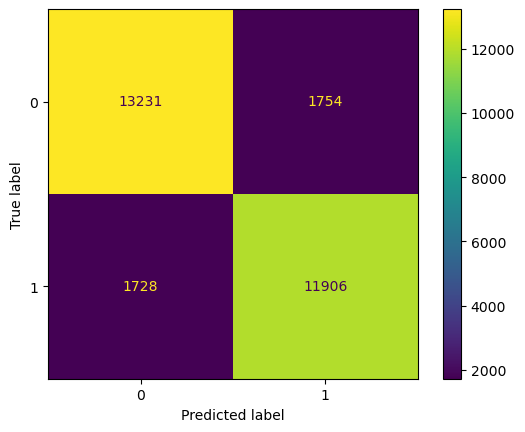

In [165]:
model_utils.plot_and_save_conf_matrix(class_actual=test_dataset['label'],
                                      class_preds=hybrid_class_preds,
                                      figure_dir_path="./../../documentation/models/sarcasm_pl_hybrid/figures",
                                      figure_filename="hybrid_test.png")

In [163]:
print(hybrid_preds[:5])
print(bert_preds[:5])

tf.Tensor(
[[0.20455293 0.79544705]
 [0.7628629  0.2371371 ]
 [0.9568038  0.04319626]
 [0.22629862 0.77370137]
 [0.53276813 0.46723187]], shape=(5, 2), dtype=float32)
tf.Tensor(
[[0.06979693 0.930203  ]
 [0.6138801  0.38611984]
 [0.98400867 0.01599133]
 [0.06063552 0.93936455]
 [0.30825564 0.6917443 ]], shape=(5, 2), dtype=float32)


In [51]:
class_preds = model_utils.get_class_preds(bert, bert_tf_dataset)

In [53]:
class_preds[:10].tolist()

[1, 0, 0, 1, 1, 0, 0, 1, 1, 0]

In [54]:
test_dataset['label'][:10]

[1, 0, 0, 1, 1, 0, 0, 1, 1, 0]

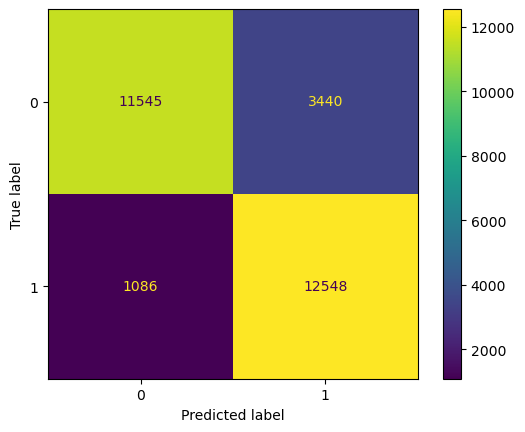

In [55]:
model_utils.plot_and_save_conf_matrix(class_actual=test_dataset['label'],
                                      class_preds=class_preds,
                                      figure_dir_path=".",
                                      figure_filename="test.png")